In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta
from time import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('/content/drive/MyDrive/elai/redvariety.xlsx')
df['Price Date'] = pd.to_datetime(df['Price Date'])
df = df.set_index('Price Date')
df = df.sort_index()

In [3]:
df.head()

Max Price
Price Date           
2010-01-01       1786
2010-01-04       1591
2010-01-05       1601
2010-01-25       1601
2010-01-27       1575

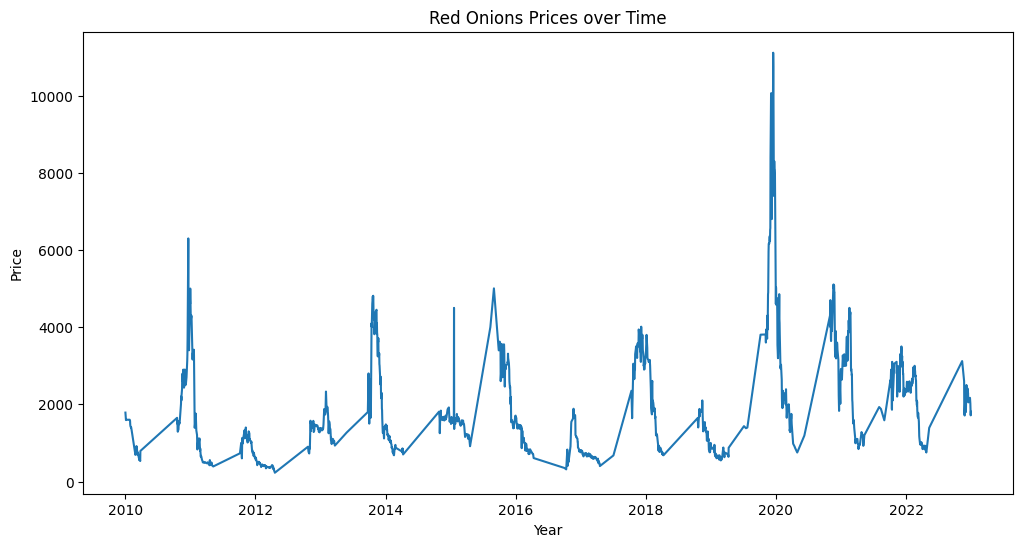

In [4]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Red Onions Prices over Time')

plt.show()


In [5]:
print(df.index.duplicated().sum())

4


In [6]:
df = df.loc[~df.index.duplicated(keep='first')]

In [7]:
ts_data = df[['Max Price']].copy()
ts_data = ts_data.asfreq('D')  # Set the frequency to daily
# Fill missing values using linear interpolation
ts_data = ts_data.interpolate(method='linear')
# Optionally, you can also perform backfill (use the next available value)
# for any remaining missing values at the beginning of the time series
ts_data = ts_data.bfill()
if ts_data.isnull().values.any():
  ts_data = ts_data.fillna(method='ffill')  # Forward fill missing values

In [8]:
ts_data

Max Price
Price Date           
2010-01-01     1786.0
2010-01-02     1721.0
2010-01-03     1656.0
2010-01-04     1591.0
2010-01-05     1601.0
...               ...
2022-12-27     2097.0
2022-12-28     2025.0
2022-12-29     1900.0
2022-12-30     1715.0
2022-12-31     1808.0

[4748 rows x 1 columns]

In [9]:
cutoff_date = pd.to_datetime('2022-01-01')
train_data = ts_data.loc[:cutoff_date]
test_data = ts_data.loc[cutoff_date + pd.DateOffset(1):]

In [10]:
from statsmodels.tsa.stattools import adfuller
adfuller_test= adfuller(ts_data)
print("pvalue of adfuller test for red onions is ",adfuller_test[1])
#if the pvalue is greater than 0.05 the series is not stationary

pvalue of adfuller test for red onions is  4.490854279697042e-05


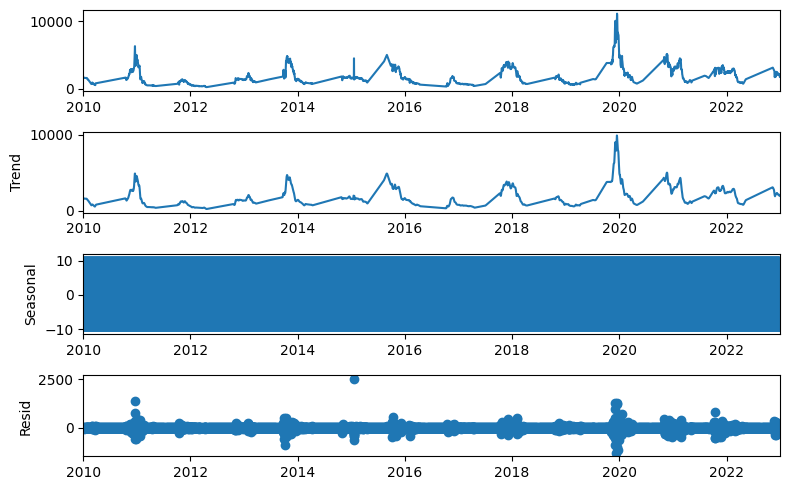

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = [8, 5]

decompose1 = seasonal_decompose(ts_data, model="additive")
decompose1.plot()
plt.show()


In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [ ]:
p=range(0,8)
q=range(0,8)
d=range(0,2)
pdq_comb = list(itertools.product(p,d,q))
len(pdq_comb)

128

In [ ]:
rmse=[]
order1=[]
for pdq in pdq_comb:
    model=ARIMA(train_data,order=pdq).fit()
    pred= model.predict(start=len(train_data),end=(len(ts_data)-1))
    error=np.sqrt(mean_squared_error(test_data,pred))
    order1.append(pdq)
    rmse.append(error)

In [ ]:
results=pd.DataFrame(index=order1,data=rmse,columns=["RMSE"])

In [ ]:
results.to_csv("Arima_results_redonions.csv")

In [ ]:
model = sm.tsa.ARIMA(train_data, order=(1, 1, 6))  # Example: ARIMA(1, 0, 0) model
trained_model = model.fit()

In [ ]:
trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Max Price   No. Observations:                 4384
Model:                 ARIMA(1, 1, 6)   Log Likelihood              -27641.091
Date:                Tue, 16 May 2023   AIC                          55298.181
Time:                        06:46:39   BIC                          55349.265
Sample:                    01-01-2010   HQIC                         55316.205
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9183      0.013     73.165      0.000       0.894       0.943
ma.L1         -0.8761      0.012    -70.626      0.000      -0.900      -0.852
ma.L2          0.0226      0.006      3.908      0.000       0.011       0.034
ma.L3         -0.0964      0.007    -12.902      0.000      -0.111      -0.082
ma.L4         -0.0333      0.009     -3.541      0.000      -0.052      -0.015
ma.L5         -0.0210      0.010     -2.142      0.032      -0.040      -0.002
ma.L6          0.1125      0.006     18.173      0.000       0.100       0.125
sigma2      1.741e+04     55.949    311.101      0.000    1.73e+04    1.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):           4451786.47
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               2.44   Skew:                            -1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                       159.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast = trained_model.get_forecast(steps=len(test_data))
predicted_prices = forecast.predicted_mean

In [ ]:
actual_prices = test_data['Max Price']
error = predicted_prices - actual_prices

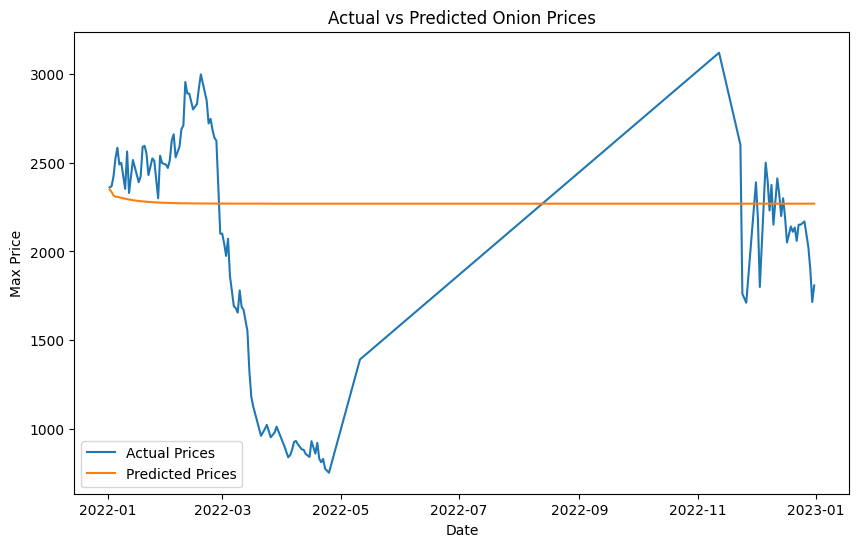

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices.index, actual_prices, label='Actual Prices')
plt.plot(predicted_prices.index, predicted_prices, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.title('Actual vs Predicted Onion Prices')
plt.legend()
plt.show()

In [ ]:
mae = np.mean(np.abs(error))
rmse = np.sqrt(np.mean(error**2))
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 531.49
Root Mean Squared Error (RMSE): 667.16


In [ ]:
#alternative method

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook


def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=train_data)

result_df

  0%|          | 0/64 [00:00<?, ?it/s]

(p, d, q)           AIC
0   (6, 1, 7)  55190.682203
1   (3, 1, 6)  55198.985582
2   (7, 1, 7)  55202.272234
3   (7, 1, 6)  55209.858992
4   (4, 1, 7)  55213.200715
..        ...           ...
59  (2, 1, 0)  55357.170879
60  (1, 1, 1)  55373.660853
61  (1, 1, 0)  55379.869449
62  (0, 1, 1)  55382.839056
63  (0, 1, 0)  55399.591472

[64 rows x 2 columns]

In [ ]:
model1 = sm.tsa.ARIMA(train_data, order=(6,1,7))  # Example: ARIMA(1, 0, 0) model
trained_model1 = model1.fit()

In [ ]:
forecast1 = trained_model1.get_forecast(steps=len(test_data))
predicted_prices1 = forecast1.predicted_mean

In [ ]:
actual_prices1 = test_data['Max Price']
error1 = predicted_prices1 - actual_prices1

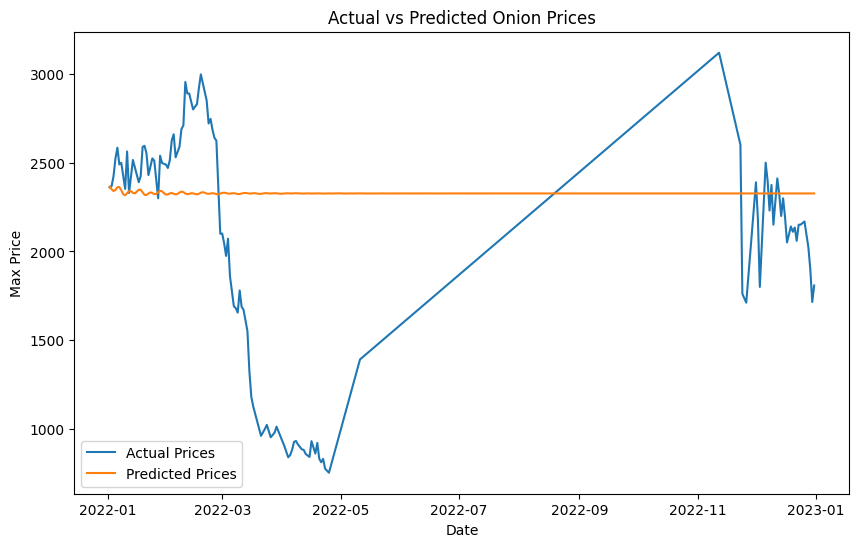

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices1.index, actual_prices1, label='Actual Prices')
plt.plot(predicted_prices1.index, predicted_prices1, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.title('Actual vs Predicted Onion Prices')
plt.legend()
plt.show()

In [ ]:
trained_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Max Price   No. Observations:                 4384
Model:                 ARIMA(6, 1, 7)   Log Likelihood              -27581.341
Date:                Tue, 16 May 2023   AIC                          55190.682
Time:                        07:06:49   BIC                          55280.079
Sample:                    01-01-2010   HQIC                         55222.224
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4969      0.218     11.472      0.000       2.070       2.923
ar.L2         -2.6069      0.714     -3.650      0.000      -4.007      -1.207
ar.L3          0.7663      1.136      0.675      0.500      -1.460       2.992
ar.L4          1.2209      1.082      1.129      0.259      -0.899       3.341
ar.L5         -1.5871      0.619     -2.564      0.010      -2.800      -0.374
ar.L6          0.6501      0.169      3.852      0.000       0.319       0.981
ma.L1         -2.4636      0.218    -11.302      0.000      -2.891      -2.036
ma.L2          2.5922      0.708      3.659      0.000       1.204       3.981
ma.L3         -0.8678      1.131     -0.767      0.443      -3.085       1.349
ma.L4         -1.0709      1.103     -0.971      0.331      -3.232       1.090
ma.L5          1.5156      0.665      2.279      0.023       0.212       2.819
ma.L6         -0.6843      0.212     -3.222      0.001      -1.101      -0.268
ma.L7          0.0532      0.021      2.567      0.010       0.013       0.094
sigma2      1.725e+04     57.355    300.741      0.000    1.71e+04    1.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           4676689.32
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                       163.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""